# ESPIRiT Demo

This is a demo of an ESPIRiT Reconstruction lifted from the MATLAB example [here](http://mrirecon.github.io/bart/examples.html#5). 

This example, ported to Python, demonstrates how users can interface with the Bart tools using the old interface and the new Pythonic version. More advanced examples can be found in the `demos` folder of the original Github repo.

In [1]:
import numpy as np
from matplotlib import pyplot as plt

## Original Python Interface

The original module includes a single function, `bart`, which allows the user to directly call command-line functions. A use case is demonstrated below.

In [2]:
from bart import bart
import cfl

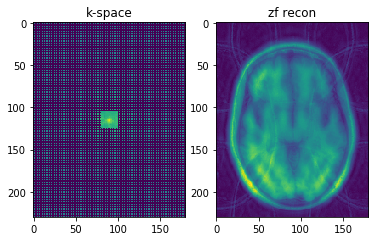

In [3]:
# load the data
und2x2 = cfl.readcfl('data/und2x2')

ksp_rss = bart(1, 'rss 8', und2x2)

zf_coils = bart(1, 'fft -i 6', und2x2)
zf_rss = bart(1, 'bart rss 8', zf_coils)

fig, axs = plt.subplots(ncols=2)

axs[0].set_title('k-space')
axs[0].imshow(abs(ksp_rss.squeeze())**0.125)

axs[1].set_title('zf recon')
axs[1].imshow(abs(zf_rss.squeeze()))

## New Python Interface

The new `tools` interface preserves the functionality and version compatibility but introduces a more Pythonic way of doing things: instead of a single BART function that can call the command line tools, the new library uses help strings to autogenerate Python bindings for the CLI tools.

Everything is packaged in the `bartpy.tools` module. Additionally, the `cfl` interface used for reading BART's datafiles has been moved to the `bartpy.utils` module.

In [4]:
import bartpy.tools
from bartpy.utils import cfl

In [5]:
# load the data
und2x2 = cfl.readcfl('data/und2x2')

Now, let's have a look at the tools interface. Functions are autogenerated from the BART documentation, using help strings to put together function signatures. For example:

In [6]:
!bart pics -h

WARN: BART version is not reproducible.
Usage: pics [-l ...] [-r f] [-R ...] [-c] [-s f] [-i d] [-t <file>] [-n] [-N] [-g] [-G d] [-p <file>] [-I] [-b d] [-e] [-W <file>] [-d d] [-u f] [-C d] [-f f] [-m] [-w f] [-S] [-L d] [-K] [-B <file>] [-P f] [-a] [-M] [-U,--lowmem] <kspace> <sensitivities> <output> 

Parallel-imaging compressed-sensing reconstruction.

-l 1/-l2         toggle l1-wavelet or l2 regularization.
-r lambda       regularization parameter
-R <T>:A:B:C    generalized regularization options (-Rh for help)
-c              real-value constraint
-s step         iteration stepsize
-i iter         max. number of iterations
-t file         k-space trajectory
-n              disable random wavelet cycle spinning
-N              do fully overlapping LLR blocks
-g              use GPU
-G gpun         use GPU device gpun
-p file         pattern or weights
-I              select IST
-b blk          Lowrank block size
-e              Scale stepsize based on max. eigenvalue
-W <img>  

This is parsed to create Python functions that call the underlying BART code. Here is an example of `pics`' Python binding.

In [7]:
help(bartpy.tools.pics)

Help on function pics in module bartpy.tools.tools:

pics(kspace, sensitivities, l=None, r=None, R=None, c=None, s=None, i=None, t=None, n=None, N=None, g=None, G=None, p=None, I=None, b=None, e=None, H=None, D=None, F=None, J=None, T=None, W=None, d=None, O=None, o=None, u=None, C=None, q=None, f=None, m=None, w=None, S=None, L=None, K=None, B=None, P=None, a=None, M=None, lowmem=None)
    Parallel-imaging compressed-sensing reconstruction.
    
    :param kspace array:
    :param sensitivities array:
    :param l SPECIAL: toggle l1-wavelet or l2 regularization. 
    :param r float: regularization parameter 
    :param R SPECIAL: generalized regularization options (-Rh for help) 
    :param c bool: real-value constraint 
    :param s float: iteration stepsize 
    :param i int: max. number of iterations 
    :param t array: k-space trajectory 
    :param n bool: disable random wavelet cycle spinning 
    :param N bool: do fully overlapping LLR blocks 
    :param g bool: use GPU 
    :

The code is entirely autogenerated, requiring little to no Python maintenance. 

**Bonus**: If a user experiments with their BART installation, new tools they generate or new flags they add to existing tools will be represented in Python.

In [6]:
# Previous example reproduced in bartPy

ksp_rss = bartpy.tools.rss(und2x2, 8)

# zero-filled recon sqrt-sum-of-squares
zf_coils = bartpy.tools.fft(und2x2, 6, i=True)
zf_rss = bartpy.tools.rss(zf_coils, 8)

ksp_rss = ksp_rss.squeeze()
zf_coils = zf_coils.squeeze()
zf_rss = zf_rss.squeeze()

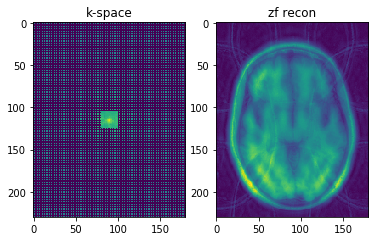

In [7]:
# TODO: plot with grey colormap

fig, axs = plt.subplots(ncols=2)

axs[0].set_title('k-space')
axs[0].imshow(abs(ksp_rss)**0.125)

axs[1].set_title('zf recon')
axs[1].imshow(abs(zf_rss))

Identical functionality!

## More Involved Usage

The new library operates on Numpy arrays, meaning that it can be integrated seemlessly with Numpy, SciPy or any other scientific Python library.

Let's start by creating a calibration matrix. This example showcases how keyword arguments in Python are parsed from the help strings.

In [8]:
help(bartpy.tools.calmat)

Help on function calmat in module bartpy.tools.tools:

calmat(kspace, k=None, K=None, r=None, R=None, C=None)
    Compute calibration matrix.
    
    :param kspace array:
    :param k list: kernel size 
    :param K list: () 
    :param r list: Limits the size of the calibration region. 
    :param R list: () 
    :param C bool: ()



Everything plays nice with Numpy:

In [9]:
# cal_mat = bart(1, "calmat -k 6 -r 20", und2x2)
cal_mat = bartpy.tools.calmat(und2x2, k=[6], r=[20])

u, sv, vh = np.linalg.svd(cal_mat)

In [10]:
cal_mat.dtype

dtype('complex64')

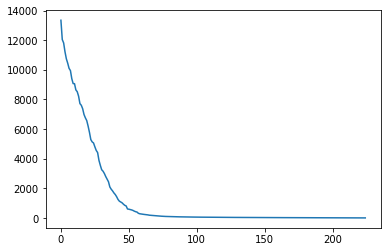

In [11]:
plt.plot(sv)

In [12]:
# emaps = bart(2, 'ecalib -r 20 -m 1', und2x2)

emaps, _ = bartpy.tools.ecalib(und2x2, r=[20]) # TODO: m=1 to throw away second set of maps

sens = emaps[..., 0]

sens_map = sens.squeeze()

In [13]:
emaps.shape

(1, 230, 180, 8, 2)

In [14]:
# Quick plotting function

def plot_maps(dat, f=abs):
    h = 16
    w = 32
    fig = plt.figure()
    cols = 4
    rows = 2
    for i in range(1, 9):
        img = dat[:,:,i-1]
        fig.add_subplot(rows, cols, i)
        plt.imshow(f(img))
    plt.show()

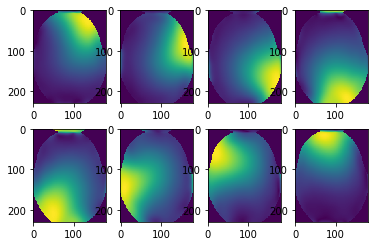

In [15]:
plot_maps(sens_map)

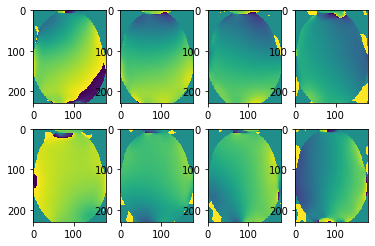

In [16]:
plot_maps(sens_map, f=np.angle)

In [17]:
emaps.shape

(1, 230, 180, 8, 2)

In [18]:
sens.shape

(1, 230, 180, 8)

In [19]:
#reco = bart(1, 'pics', und2x2, sens).squeeze()
reco = bartpy.tools.pics(und2x2, sens).squeeze()

In [20]:
reco.shape

(230, 180)

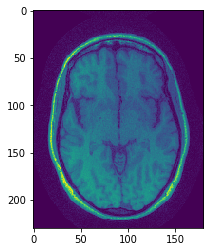

In [21]:
plt.imshow(abs(reco))